# https://www.kaggle.com/code/bhatnagardaksh/gradient-descent-from-scratch#Logistic-Regression-Model-Training

In [1]:
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (22, 5)
plt.rcParams['figure.dpi'] = 100

import sqlite3

from sklearn.metrics import r2_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from urllib.request import urlretrieve

<h1>Data import</h1>

In [2]:
CSV_NAME = 'medical.csv'

medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
urlretrieve(medical_charges_url, CSV_NAME)

('medical.csv', <http.client.HTTPMessage at 0x1d03bc5db10>)

In [3]:
medical_df = pd.read_csv(CSV_NAME)
print(medical_df.shape)
medical_df.head()


(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<h1>Data analysis</h1>
Skippable

In [6]:
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

medical_df.to_sql('data', conn, if_exists='replace', index=False)

def run_query(query):
    cursor.execute(query)
    results = cursor.fetchall()
    df = pd.DataFrame(results, columns=[description[0] for description in cursor.description])
    return df

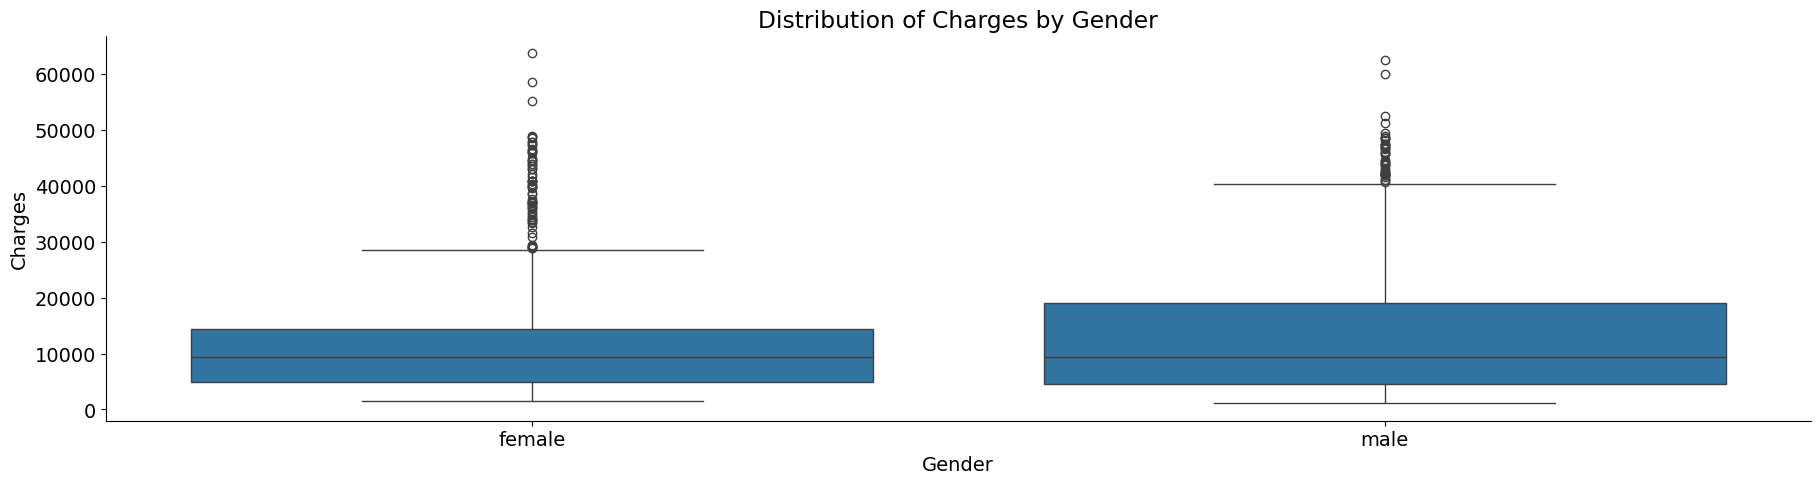

In [7]:
sns.boxplot(medical_df, x='sex', y='charges')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Distribution of Charges by Gender')
plt.xlabel('Gender')
plt.ylabel('Charges')
plt.show()

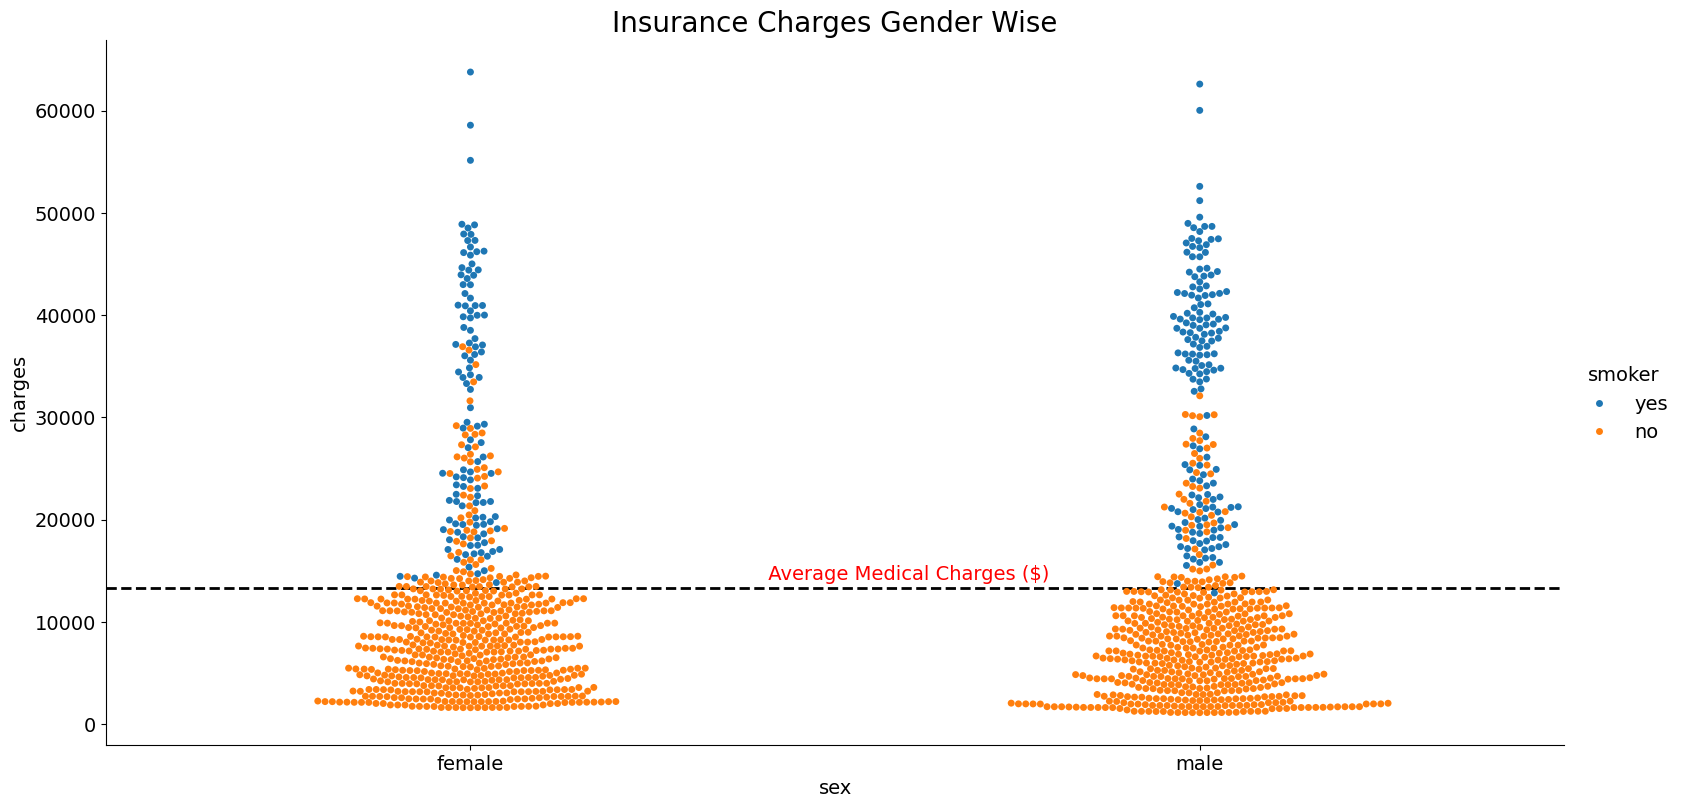

In [8]:
sns.catplot(data=medical_df,x= 'sex',y='charges', kind='swarm', hue='smoker', aspect =2, height=8)
plt.axhline(medical_df['charges'].mean(), linestyle='--', lw=2, zorder=1, color='black')
plt.annotate(f' Average Medical Charges ($)', (.4, medical_df['charges'].mean()+900), fontsize=14,color='red')
plt.title('Insurance Charges Gender Wise', fontsize=20)
plt.show()

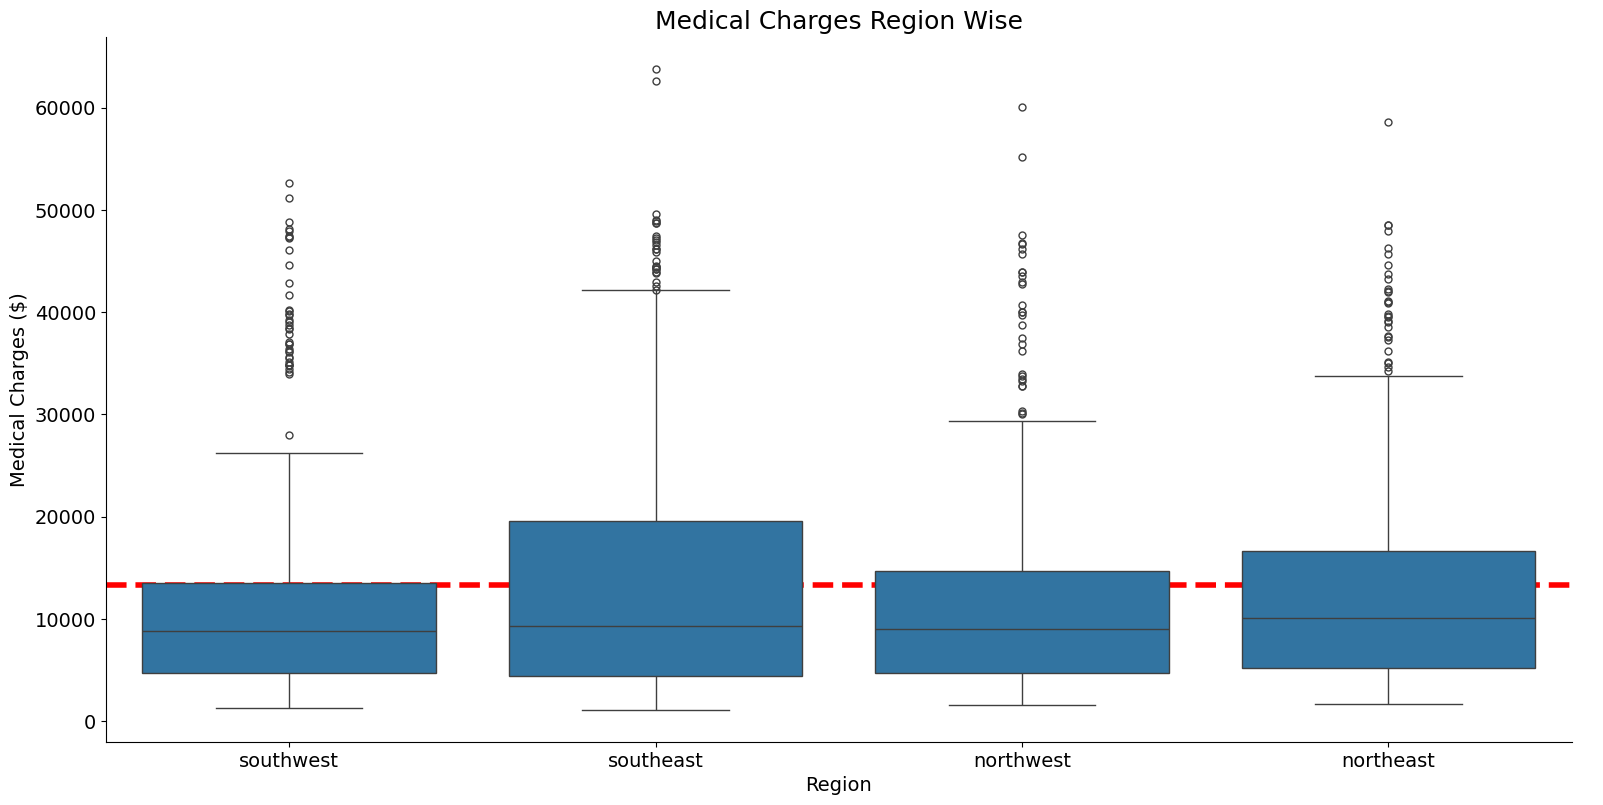

In [9]:
sns.catplot(data=medical_df,x= 'region',y='charges', kind='box', aspect =2, height=8)
plt.axhline(medical_df['charges'].mean(), linestyle='--', lw=4, zorder=1, color='red')
plt.title('Medical Charges Region Wise', fontsize=18)
plt.xlabel('Region')
plt.ylabel('Medical Charges ($)')
plt.show()

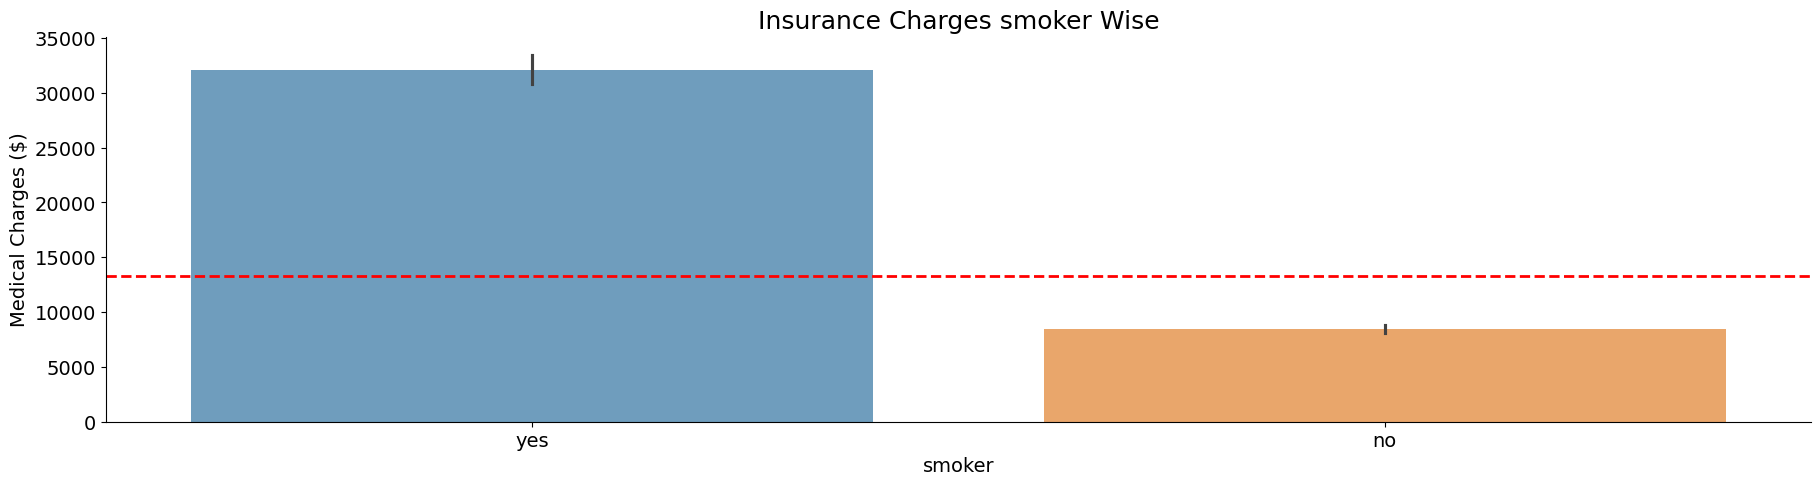

In [10]:
sns.barplot(data=medical_df,x= 'smoker',y='charges', hue='smoker', alpha=0.7, dodge=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axhline(medical_df['charges'].mean(), linestyle='--', lw=2, zorder=1, color='red')
plt.title('Insurance Charges smoker Wise', fontsize=18)
plt.ylabel('Medical Charges ($)')
plt.show()

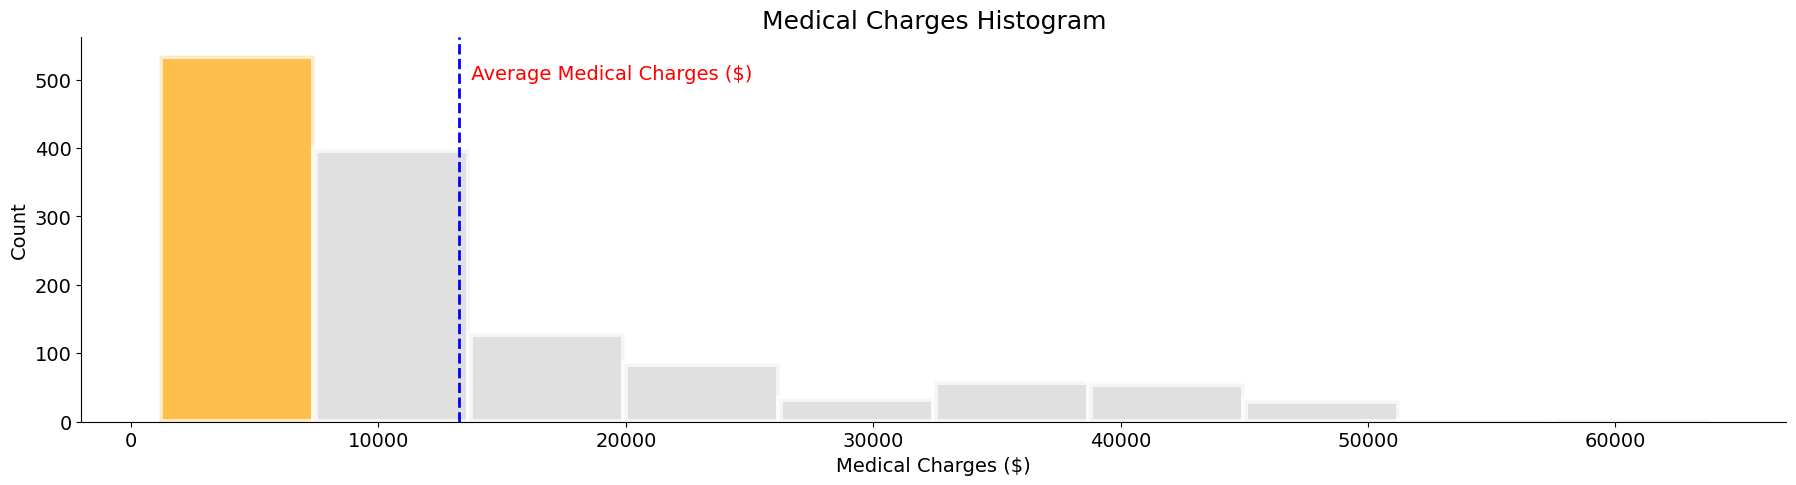

In [11]:
fig, ax = plt.subplots()
N, bins, patches = ax.hist(np.array(medical_df.charges), edgecolor='white', color='lightgray',linewidth=5, alpha=0.7)
for i in range(0,1):
    patches[i].set_facecolor('orange')
    plt.title('Medical Charges Histogram', fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Medical Charges ($)')
    plt.ylabel('Count')
    plt.axvline(medical_df['charges'].mean(), linestyle='--', lw=2, zorder=1, color='blue')
    plt.annotate(f' Average Medical Charges ($)', (13500, 500), fontsize=14,color='red')
    plt.show()

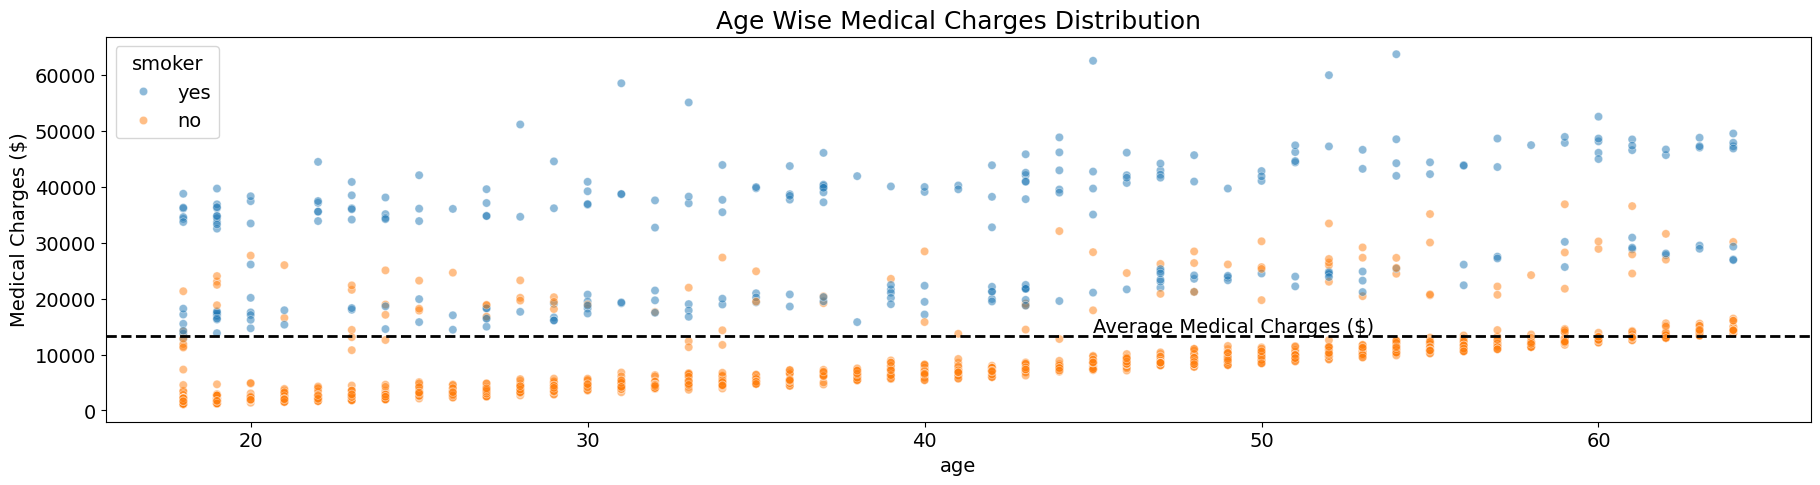

In [12]:
sns.scatterplot(y=medical_df['charges'], x=medical_df['age'], hue=medical_df['smoker'], alpha=0.5)
plt.axhline(medical_df['charges'].mean(), linestyle='--', lw=2, zorder=1, color='black')
plt.annotate(f'Average Medical Charges ($)', (45, 13900))
plt.title('Age Wise Medical Charges Distribution', fontsize=18)
plt.ylabel('Medical Charges ($)')
plt.show()

Text(0.5, 1.0, "Smoker's charges vs bmi")

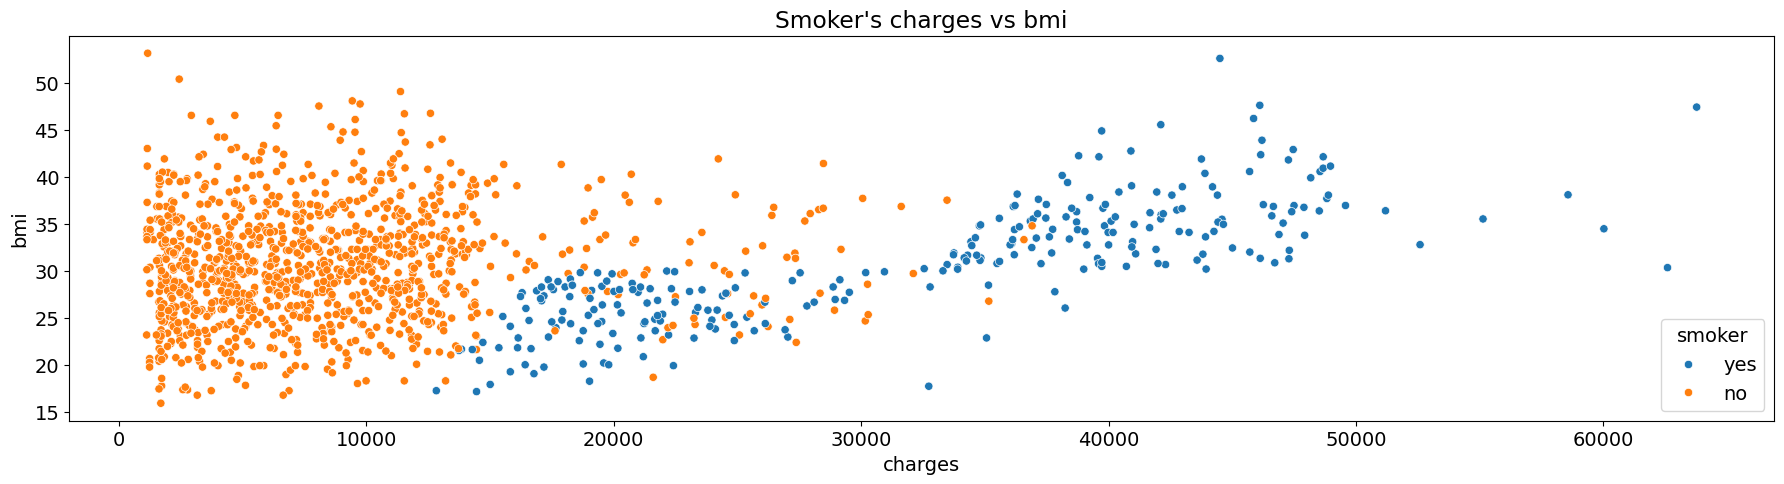

In [13]:
sns.scatterplot(medical_df, x=medical_df['charges'], y=medical_df['bmi'], hue=medical_df['smoker'])

plt.title("Smoker's charges vs bmi")

<h1>Data cleaning</h1>



<h2><b>Outlier detection and removal </b></h2>


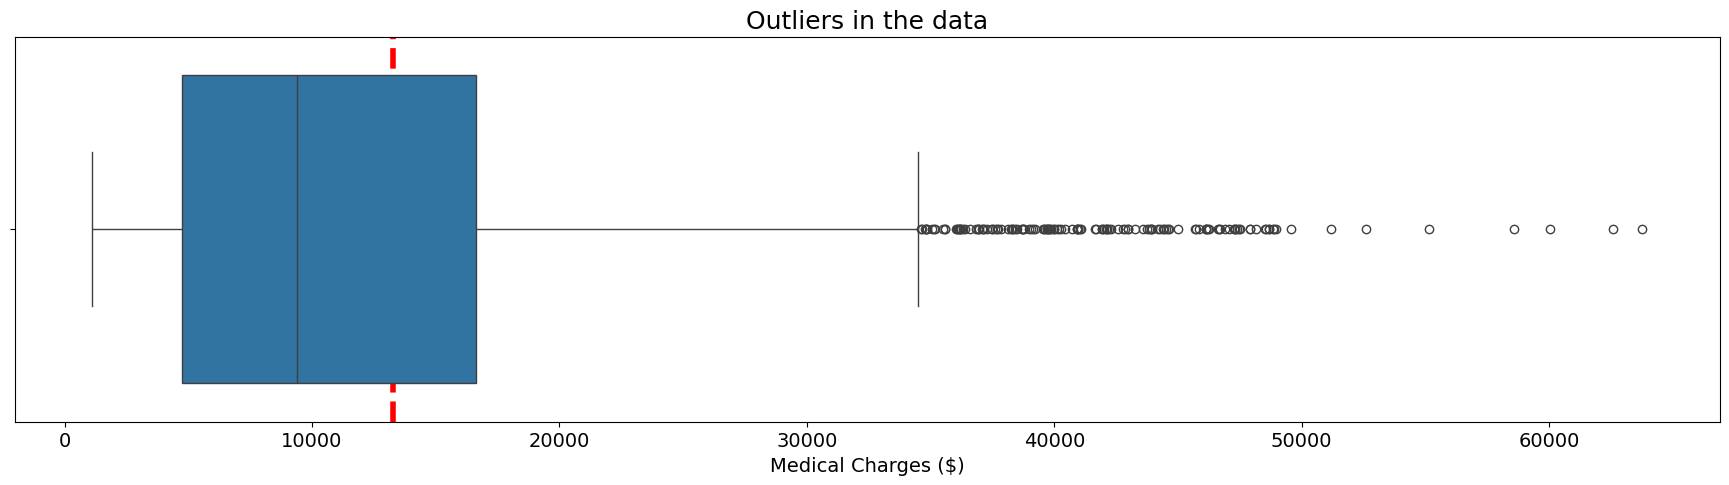

In [14]:
sns.boxplot(x=medical_df['charges'])

plt.axvline(medical_df['charges'].mean(), linestyle='--', lw=4, zorder=1, color='red')

plt.title('Outliers in the data', fontsize=18)
plt.xlabel('Medical Charges ($)')
plt.show()

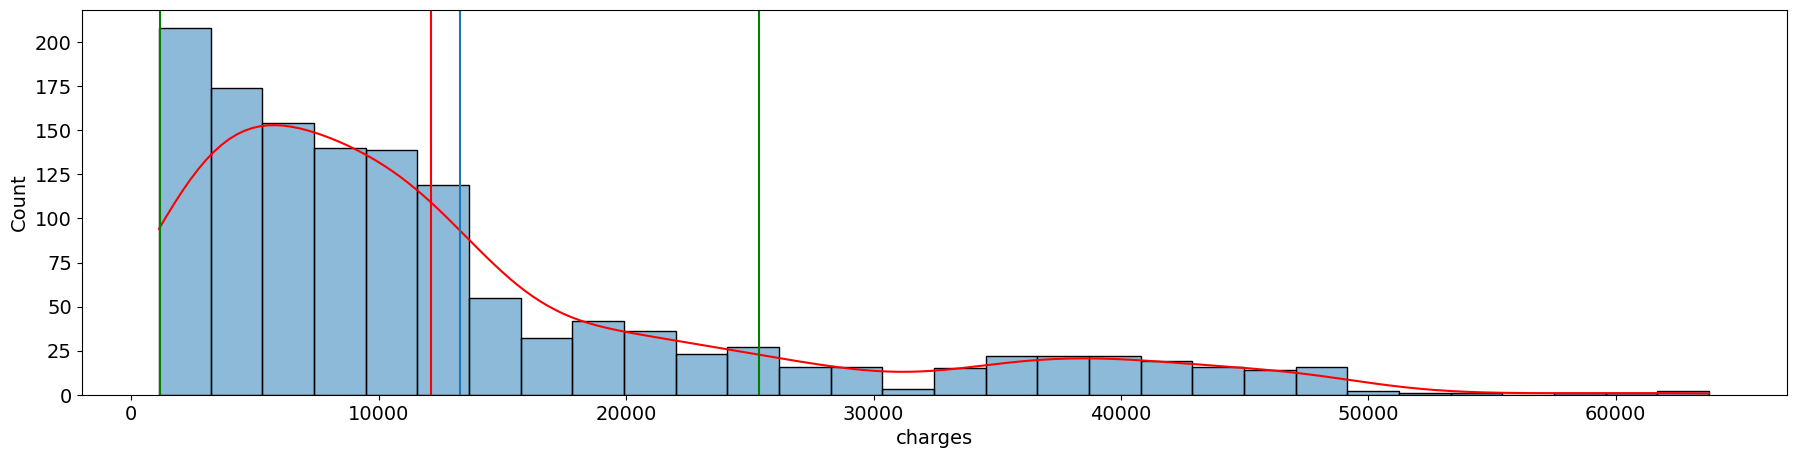

In [15]:
ax = sns.histplot(medical_df, x=medical_df['charges'], kde=True)
ax.lines[0].set_color('red')
plt.axvline(medical_df['charges'].mean())
plt.axvline(medical_df['charges'].std(), color='r')
plt.axvline(medical_df['charges'].mean() + medical_df['charges'].std(), color='g')
plt.axvline(medical_df['charges'].mean() - medical_df['charges'].std(), color='g')

Cut Off = 36316.455
Lower = -23046.033
Upper = 49586.877


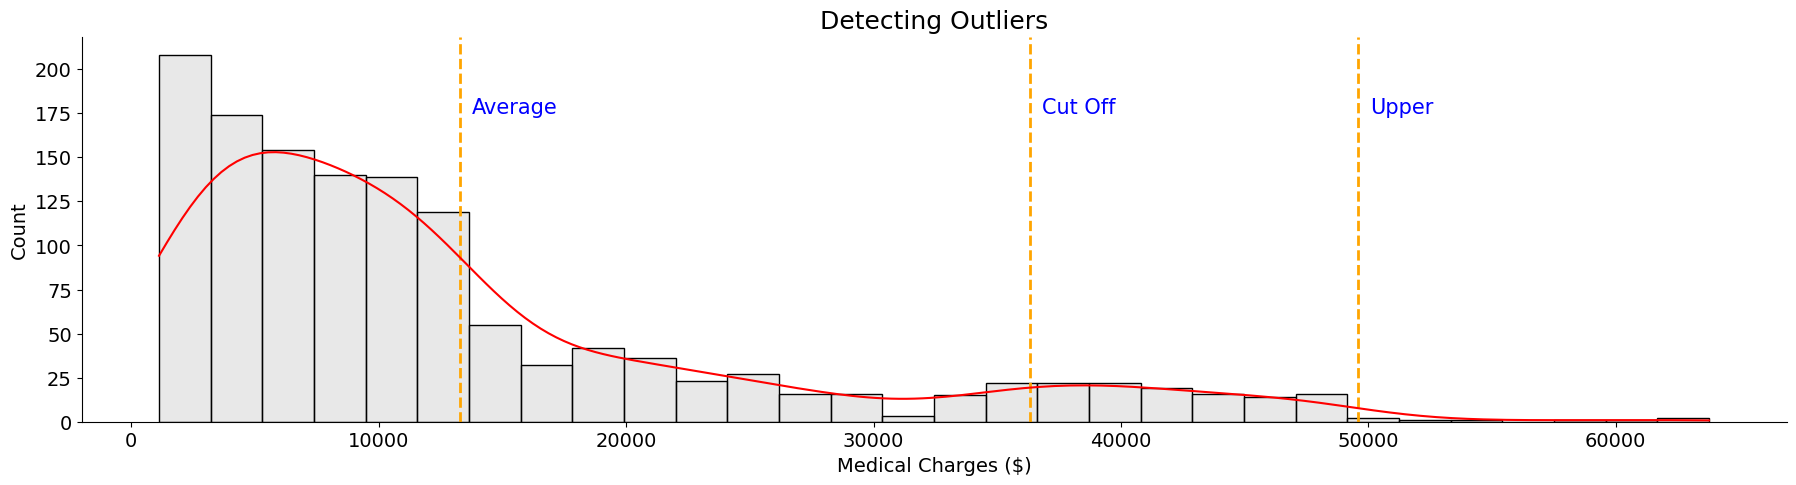

In [16]:
# Extract the 'charges' column values from the medical_df DataFrame and sort them
data = sorted(medical_df['charges'].values)

# Calculate the mean and standard deviation of the sorted 'charges' data
data_mean, data_std = np.mean(data), np.std(data)

# Calculate the cutoff value, which is three times the standard deviation
cut_off = data_std * 3

# Calculate the lower and upper bounds for identifying potential outliers
lower, upper = data_mean - cut_off, data_mean + cut_off

# Print the calculated values with appropriate labels
print('Cut Off =', round(cut_off, 3))  # Display the calculated cutoff value
print('Lower =', round(lower, 3))      # Display the calculated lower bound for potential outliers
print('Upper =', round(upper, 3))      # Display the calculated upper bound for potential outliers

ax = sns.histplot(medical_df['charges'], kde=True, color='lightgray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False);
ax.lines[0].set_color('red')
plt.axvline(data_mean, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Average', (data_mean+500, 175), fontsize=15, color='blue')

plt.axvline(upper, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Upper', (upper+500, 175), fontsize=15, color='blue')

plt.axvline(cut_off, linestyle='--', lw=2, zorder=1, color='orange')
plt.annotate(f'Cut Off', (cut_off+500, 175), fontsize=15, color='blue')

plt.title('Detecting Outliers', fontsize=18)
plt.xlabel('Medical Charges ($)')
plt.show()

In [17]:
print('The shape of our dataframe before the Outlier Removal is', medical_df.shape)
medical_df = medical_df[medical_df['charges'] < upper]
medical_df = medical_df[medical_df['charges'] > lower]
print('The shape of our dataframe after the Outlier Removal is', medical_df.shape)

The shape of our dataframe before the Outlier Removal is (1338, 7)
The shape of our dataframe after the Outlier Removal is (1331, 7)


In [18]:
df = medical_df.copy()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<h2><b>Encoding</b></h2>


In [19]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_cols = df.select_dtypes(include='object').columns
encoder.fit(df[cat_cols])


OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [20]:
onehot = encoder.transform(df[cat_cols])
encoder.categories_
display(df)
print(df.shape)
print(onehot)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


(1331, 7)
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 1.]
 [1. 0. 0. ... 1. 0. 0.]]


In [21]:
encoded_cols = [['female', 'male','smokerno', 'smokeryes', 'northeast', 'northwest', 'southeast', 'southwest']]
df[['female', 'male','smokerno', 'smokeryes', 'northeast', 'northwest', 'southeast', 'southwest']] = onehot
df.drop(cat_cols, axis=1, inplace=True )
df.head()

,age,bmi,children,charges,female,male,smokerno,smokeryes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


<h2>Scaling and normalization</h2>

In [22]:
scaler = MinMaxScaler()

y = df['charges'].values
X = df.drop('charges', axis=1).values

print(X.shape)
print(y.shape)

(1331, 11)
(1331,)


<h1>Building a model and training</h1>

In [23]:
# Gradient Descent Function for linear regression
def regression_gradient_descent(X_train, y_train, m, b):
    # Predictions using the linear equation y = mx + b
    yhat = np.dot(X_train, m) + b

    # Mean Squared Error (MSE) calculation
    MSE = (np.sum((y_train - yhat)**2)) / N

    # R-squared calculation to measure the goodness of fit
    r_squared = r2_score(y_train, yhat)

    # Calculate the gradient of the loss function with respect to intercept 'b'
    loss_slope_b = -(2/N) * sum(y_train - yhat)

    # Calculate the gradient of the loss function with respect to the slope 'm'
    loss_slope_m = -(2/N) * (np.dot((y_train - yhat), X_train))

    # Update the slope 'm' and intercept 'b' using the gradient descent update rule
    m = m - (learning_rate * loss_slope_m)
    b = b - (learning_rate * loss_slope_b)

    return m, b, MSE, r_squared

# Function for calculating the EarlyStopping criteria by comparing consecutive losses
def EarlyStopping(loss):
    for i in range(1, len(loss)):
        yield (loss[i-1], loss[i])

# Function to determine the number of batches based on batchsize and the size of the dataset
def batch_size(batchsize, X):
    batches = round(X.shape[0] // batchsize)
    return batches

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

(1064, 11)


In [24]:
# Set a random seed for reproducibility
np.random.seed(0)

# Calculate the total number of data points
N = X.shape[0]

# Set the initial learning rate, decay rate, and other variables
learning_rate = 0.2
decay_rate = 0.01
LR = []  # List to store learning rates
ValidationLoss = []  # List to store validation loss
Trainingloss = []  # List to store training loss
batchsize = 30

# Initialize the intercept and slope
Intercept = []
Slope = []
m = np.ones(X.shape[1])  # Initializing some initial values for the slope
b = 1  # Initializing some initial values for the intercept
print('The initial Value of w and b are', m, b)

# Calculate the number of batches
batches = batch_size(batchsize, X)

num_epochs =  2000

# Loop over multiple epochs for training
for i in range(num_epochs):
    epoch = i
    
    # Loop over batches within the current epoch
    for j in range(batches):
        if i == 0:
            # Initial epoch updates (no decay rate applied)
            if j % batchsize == 0:
                learning_rate = learning_rate  # Maintain initial learning rate
                np.random.seed(0)
                np.random.shuffle([X_train_scaled, y_train])
                m, b, MSE, r_squared = regression_gradient_descent(X_train_scaled, y_train, m, b)
                m_test, b_test, MSE_test, r_squared_test = regression_gradient_descent(X_test_scaled, y_test, m, b)
            else:
                m = m
                b = b
        else:
            # Updates with decay rate applied
            if j % batchsize == 0:
                learning_rate = [(1 / (1 + decay_rate)) * learning_rate for j in range(batches)][0]
                np.random.seed(0)
                np.random.shuffle([X_train_scaled, y_train])
                m, b, MSE, r_squared = regression_gradient_descent(X_train_scaled, y_train, m, b)
                m_test, b_test, MSE_test, r_squared_test = regression_gradient_descent(X_test_scaled, y_test, m, b)
            else:
                m = m
                b = b

    # Store values for analysis and tracking
    Intercept.append(b)
    Slope.append(m)
    Trainingloss.append(MSE)
    ValidationLoss.append(MSE_test)
    LR.append(learning_rate)
    
    # Print progress every 20 epochs
    if i % 100 == 0:
        print(f'Epoch: {i}/{num_epochs} [==============================] - Loss: {MSE:.2e} - val Loss: {MSE_test:.2e} - r-squared: {round(r_squared, 4)} - val_r-squared: {ro

The initial Value of w and b are [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 1
Epoch: 0/2000 [==============================] - Loss: 1.03e+08 - val Loss: 2.82e+07 - r-squared: 0.0134 - val_r-squared: 0.1139
Epoch: 100/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.55e+06 - r-squared: 0.7408 - val_r-squared: 0.7631
Epoch: 200/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.51e+06 - r-squared: 0.7414 - val_r-squared: 0.7643
Epoch: 300/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.50e+06 - r-squared: 0.7415 - val_r-squared: 0.7645
Epoch: 400/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.50e+06 - r-squared: 0.7415 - val_r-squared: 0.7645
Epoch: 500/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.50e+06 - r-squared: 0.7415 - val_r-squared: 0.7645
Epoch: 600/2000 [==============================] - Loss: 2.71e+07 - val Loss: 7.50e+06 - r-squared: 0.7415 - val_r-squared: 0.7645
Epoch: 700/2000

[772992.60229216 615949.39084164 565512.26520028 612493.57122199
 532714.66658451 482078.31922731] [11534.87265  3693.428    3238.4357  38746.3551   4058.71245  1534.3045 ]


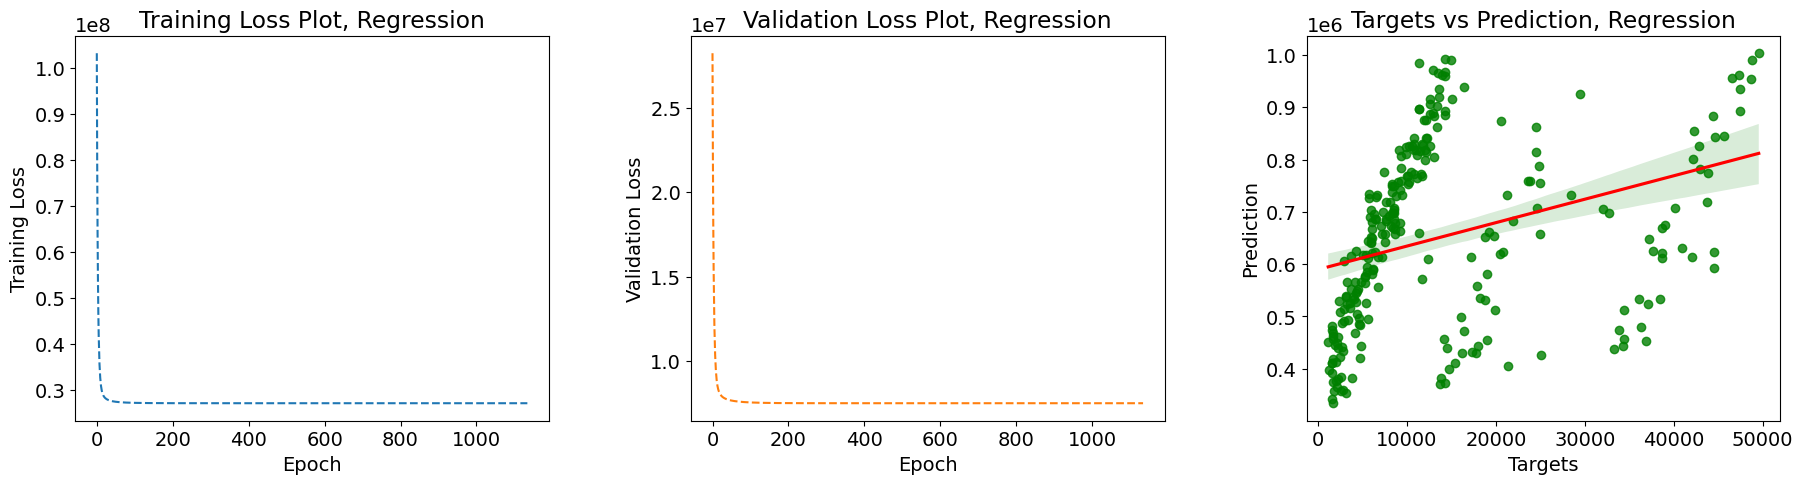

In [27]:
# Get the coefficient (slope) and intercept values for the current epoch
coefficient = Slope[epoch]
intercept = Intercept[epoch]

# Predictions using the linear regression equation y = mx + b
y_pred = np.dot(X_test, coefficient) + intercept

print(y_pred[:6], y_test[:6])

# Create a DataFrame to compare predicted and actual values
df = pd.DataFrame(y_pred, y_test, columns=['y']).reset_index().rename(columns={'index': 'y', 'y': 'y_pred'})

# Plotting the Figures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 5))
fig.subplots_adjust(hspace=.2, wspace=.3)

# First Plot: Training Loss Plot
ax1.plot(Trainingloss, linestyle='--')
ax1.set_title("Training Loss Plot, Regression")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')

# Second Plot: Validation Loss Plot
ax2.plot(ValidationLoss, 'tab:orange', linestyle='dashed', markersize=5)
ax2.set_title("Validation Loss Plot, Regression")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')

# Third Plot: Scatter Plot of Targets vs. Predictions
ax3 = sns.regplot(data=df, x=df['y'], y=df['y_pred'], color='green', fit_reg=True)
ax3.lines[0].set_color('red')
ax3.set_title('Targets vs Prediction, Regression')
ax3.set_xlabel('Targets')
ax3.set_ylabel('Prediction')

# Display the plots
plt.show()